_Version log: Branch of V19. Optimisation using MCMC Metropolis._

In [6]:
import sys, warnings
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
from sklearn.exceptions import ConvergenceWarning
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft as spfft
from tqdm import tqdm
warnings.filterwarnings("ignore", category= ConvergenceWarning)
plt.rcParams.update({'font.size':16})
np.set_printoptions(threshold=sys.maxsize)

In [7]:
def open_dataset(file_name, file_type):
    if file_type == ".csv":
        array = np.genfromtxt("data\\" +file_name +file_type, delimiter=",", filling_values= np.nan)
    elif file_type == ".txt":
        array = np.genfromtxt("data\\" +file_name +file_type, delimiter=",", filling_values= np.nan)
    else:
        raise ValueError("{0:} is not a regonised file type.".format(file_type))
    return array

def compressed_sensing(samples, locations, total_points, alpha):

    cropping_matrix = np.identity(total_points, dtype= np.float16)
    cropping_matrix = cropping_matrix[locations] #cropping matrix operator
    dct_matrix = spfft.idct(np.identity(total_points), axis= 0, norm= "forward")
    measurement_matrix = np.matmul(cropping_matrix, dct_matrix)

    lasso = Lasso(alpha= alpha)
    lasso.fit(measurement_matrix, samples)

    result = spfft.idct(lasso.coef_, norm= "forward")

    return result


def subsample_1d(total_points, subsampling_percentage = 0.5, subsampling_method = "random"):

    if subsampling_method == "random":
        reduced_points = round(total_points *subsampling_percentage)
        subsampled_points = np.random.choice(total_points, reduced_points, replace= False)

    if subsampling_method == "regular":
        reduced_points = round(total_points *subsampling_percentage)
        subsampled_points = np.round(np.linspace(0, total_points -1, reduced_points)).astype(int)
     
    subsampled_points = np.sort(subsampled_points) #Nessisary only for optimisation.

    return subsampled_points

In [8]:
file_name = "1dmock3"
file_type = ".csv"

target = open_dataset(file_name, file_type)
total_points = len(target)

In [9]:
iterations = 100000
subsample_percentage = 0.05
regularization_coeffient = 1e-4 # DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e-2)
stepsize = 3
min_seperation = 2

reduced_points = round(total_points *subsample_percentage)
detectors = subsample_1d(total_points, subsample_percentage, "regular")
original_detectors = np.copy(detectors) #Tell python not to do it's low level memory-saving pointer thing.

print(total_points, reduced_points)

320 16


In [10]:
#########INITAILISATION##########

detector_configerations = np.array(detectors)
scores = np.array([])

result = compressed_sensing(target[detectors], detectors, total_points, regularization_coeffient)
score = np.linalg.norm(target -result)

#######START MCMC Metropolis###########

for n in tqdm(range(iterations)):
    steps = stepsize #reset steps
    new_detectors = detectors #reset detectors
    new_score = score #reset score

    while steps > 0:
        random_detector = np.random.randint(0, reduced_points) #random number between 0 and reduced_points. Includes 0. Excludes reduced_points

        current = new_detectors[random_detector]
        previous = -1 if random_detector == 0 else new_detectors[random_detector -1]
        next = total_points if random_detector == reduced_points -1 else new_detectors[random_detector +1]

        if previous +min_seperation < current and current < next -min_seperation:
            #detector has space to move forward or back.
            new_detectors[random_detector] += np.random.choice([-1,1])
            steps -= 1
        elif previous +min_seperation < current:
            #detector has space to move back.
            new_detectors[random_detector] -= 1
            steps -= 1
        elif current < next -min_seperation:
            #detector has space to move forward.
            new_detectors[random_detector] += 1
            steps -= 1
        else:
            #detector can't move.
            pass


    new_result = compressed_sensing(target[new_detectors], new_detectors, total_points, regularization_coeffient)
    new_score = np.linalg.norm(target -new_result)
    acceptance = np.exp(score -new_score) # Normally MCMC uses `new_score /score` but I am looking for a minimum point so this scheme is better.

    detector_configerations = np.vstack((detector_configerations, new_detectors))

    if acceptance > np.random.rand():
        detectors = new_detectors
        score = new_score

    scores = np.append(scores, score)

  0%|          | 5/100000 [00:00<37:19, 44.64it/s]

100%|██████████| 100000/100000 [28:09<00:00, 59.20it/s]


In [11]:
###FINALISATION AFTER LOOP

best_iteration = np.argmin(scores)
detectors = detector_configerations[best_iteration]
result = compressed_sensing(target[detectors], detectors, total_points, regularization_coeffient)

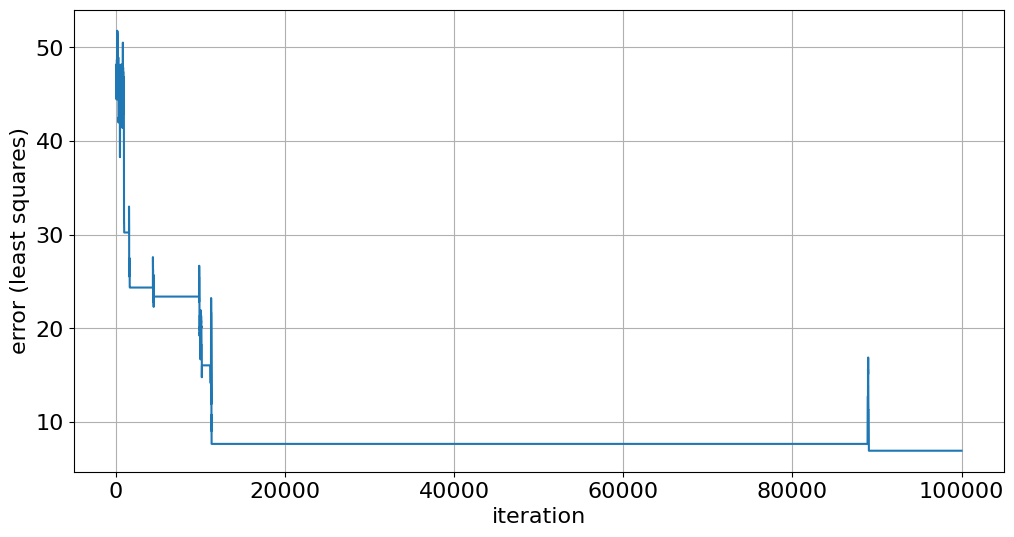

In [12]:
fig, axs = plt.subplots(figsize= (12,6))

axs.plot(scores)
axs.grid(True)
axs.set(ylabel= "error (least squares)", xlabel= "iteration")

plt.show()

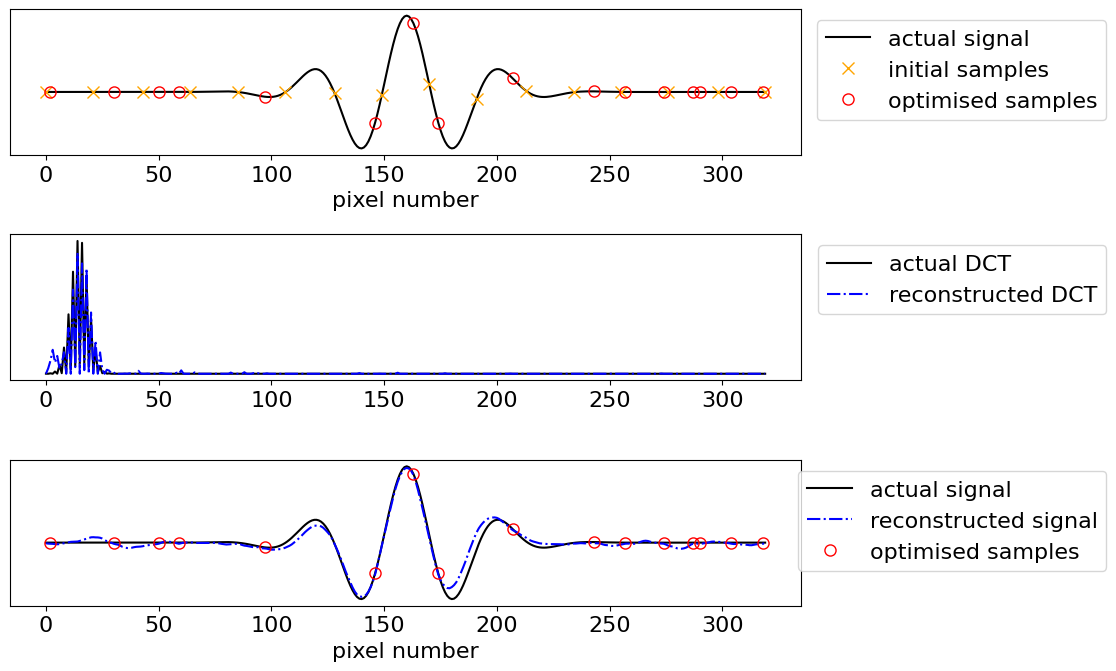

In [13]:
result_DCT = spfft.dct(result, norm= "forward")
target_DCT = spfft.dct(target, norm= "forward")


plt.rcParams.update({'font.size':16})
fig, axs = plt.subplots(3,1, figsize= (12,7))

axs[0].plot(target, color= "k", label= "actual signal")
axs[0].plot(original_detectors, target[original_detectors], marker= "x", markerfacecolor= "None", markersize= 8, color= "orange", linestyle= "None", label= "initial samples")
axs[0].plot(detectors, target[detectors], marker= "o", markerfacecolor= "None", markersize= 8, color= "red", linestyle= "None", label= "optimised samples")
axs[0].set(xlabel= "pixel number")

axs[1].plot(np.abs(target_DCT), color= "k", label= "actual DCT")
axs[1].plot(np.abs(result_DCT), color= "blue", label= "reconstructed DCT", linestyle= "-.")

axs[2].plot(target, color= "k", label= "actual signal")
axs[2].plot(result, color= "blue", label= "reconstructed signal", linestyle= "-.")
axs[2].plot(detectors, target[detectors], marker= "o", markerfacecolor= "None", markersize= 8, color= "red", linestyle= "None", label= "optimised samples")
axs[2].set(xlabel= "pixel number")

[ax.legend(loc= 'upper right', bbox_to_anchor=(1.4, 1)) for ax in axs]
[ax.set(yticks= []) for ax in axs]

plt.tight_layout()
plt.show()